In [21]:
import torch
from ptbxlae.modeling.multiCycleConv import RpeakVAE
from ptbxlae.dataprocessing.ptbxlDS import PtbxlSigWithRpeaksDS
import matplotlib.pyplot as plt

In [22]:
torch.no_grad()
m = RpeakVAE.load_from_checkpoint('../cache/savedmodels/last-v15.ckpt')
m = m.eval()
m

RpeakVAE(
  (encoder): Sequential(
    (0): Conv1d(12, 24, kernel_size=(7,), stride=(2,), padding=(3,))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv1d(24, 48, kernel_size=(7,), stride=(2,), padding=(3,))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mean): Linear(in_features=60000, out_features=10, bias=True)
  (fc_logvar): Linear(in_features=60000, out_features=10, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=60000, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Unflatten(dim=1, unflattened_size=(48, 1250))
    (3): ConvTranspose1d(48, 24, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (4): LeakyReLU(negative_slope=0.01)
    (5): ConvTranspose1d(24, 12, kernel_size=(7,), stride=(2,), padding=(3,), output_padding=(1,))
    (6): LeakyReLU(negative_slope=0.01)
  )
)

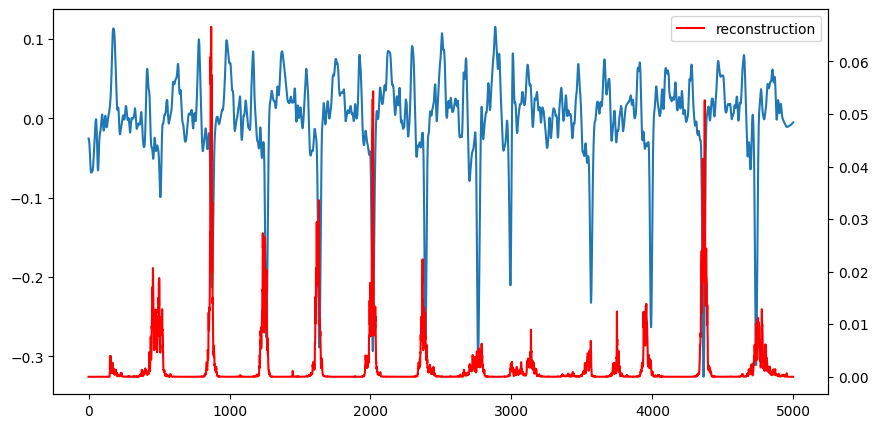

In [28]:

SAMPLE_IDX = 900
CHANNEL = 2
ds = PtbxlSigWithRpeaksDS(root_folder="../data")

sig, rpeaks = ds[SAMPLE_IDX]

latent_representation = m.encode(sig.unsqueeze(0).to('cuda'))
# reconstruction = m.generate(latent_representation, smoothing_iterations=10).squeeze().detach().cpu()
reconstruction = torch.mean(
    torch.stack([m.decode(latent_representation) for idx in range(0, 100)]), dim=0
).squeeze().detach().cpu()
orig_plot = sig[CHANNEL]
recon_plot = reconstruction[CHANNEL]

orig_plot.shape
plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()

ax_rpeaks = ax.twinx()

# ax.set_title(f"Reconstruction Loss {mse_loss(orig_plot, recon_plot):.5f}")
ax.plot(range(0, 5000), orig_plot, label='original')
ax_rpeaks.plot(range(0, 5000), recon_plot, label='reconstruction', color='red')
plt.legend(loc='best')